# Image processing

## Functions 

In [1]:
def img_processing(img_file, img_dim = (640,640)):
    import cv2

    ## Read image ##
    img = cv2.imread(img_file) # BGR
    
    ## Conver to gray scale ##
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Invert the grayscale image
    img = cv2.bitwise_not(img)
    
    ## Resize imgage ##
    img = cv2.resize(img, img_dim, interpolation=cv2.INTER_LANCZOS4)
    
    ## Conver image from gray scale to BGR (H,W,C) ##
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    return img    


def print_image(img):
    import matplotlib.pyplot as plt

    #####################################
    #### Function to plot the images ####
    #####################################

    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.title(f"Img - {img.shape}")
    plt.xticks([])
    plt.yticks([])
    plt.show()


## Code

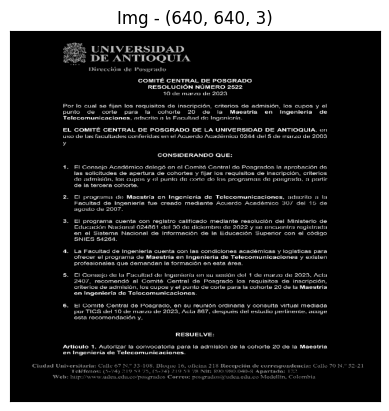

In [2]:
import os
import cv2
import numpy as np


#### Params ####
doc_folder = "../../Data/Example_Docs/img/doc/"
img_dim = (640,640)

#### Code ####

## List doc images ##
img_list = os.listdir(doc_folder)
# Sort the list of files by name
img_list = sorted(img_list)

## Loop to iterate throught images ##
img_file = os.path.join(doc_folder, img_list[0])

img = img_processing(img_file, img_dim)

print_image(img)


# YOLO abstraction

## Functions

In [7]:
from pathlib import Path
import os
import glob
import cv2
import numpy as np



IMG_FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp'  # include image suffixes
VID_FORMATS = 'asf', 'avi', 'gif', 'm4v', 'mkv', 'mov', 'mp4', 'mpeg', 'mpg', 'ts', 'wmv'  # include video suffixes



class LoadImages:
    # YOLOv5 image/video dataloader, i.e. `python detect.py --source image.jpg/vid.mp4`
    def __init__(self, path, img_size=640, stride=32, auto=True):
        files = []
        for p in sorted(path) if isinstance(path, (list, tuple)) else [path]:
            p = str(Path(p).resolve())
            if '*' in p:
                files.extend(sorted(glob.glob(p, recursive=True)))  # glob
            elif os.path.isdir(p):
                files.extend(sorted(glob.glob(os.path.join(p, '*.*'))))  # dir
            elif os.path.isfile(p):
                files.append(p)  # files
            else:
                raise FileNotFoundError(f'{p} does not exist')

        images = [x for x in files if x.split('.')[-1].lower() in IMG_FORMATS]
        videos = [x for x in files if x.split('.')[-1].lower() in VID_FORMATS]
        ni, nv = len(images), len(videos)

        self.img_size = img_size
        self.stride = stride
        self.files = images + videos
        self.nf = ni + nv  # number of files
        self.video_flag = [False] * ni + [True] * nv
        self.mode = 'image'
        self.auto = auto
        if any(videos):
            self.new_video(videos[0])  # new video
        else:
            self.cap = None
        assert self.nf > 0, f'No images or videos found in {p}. ' \
                            f'Supported formats are:\nimages: {IMG_FORMATS}\nvideos: {VID_FORMATS}'

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count == self.nf:
            raise StopIteration
        path = self.files[self.count]

        if self.video_flag[self.count]:
            # Read video
            self.mode = 'video'
            ret_val, img0 = self.cap.read()
            while not ret_val:
                self.count += 1
                self.cap.release()
                if self.count == self.nf:  # last video
                    raise StopIteration
                path = self.files[self.count]
                self.new_video(path)
                ret_val, img0 = self.cap.read()

            self.frame += 1
            s = f'video {self.count + 1}/{self.nf} ({self.frame}/{self.frames}) {path}: '

        else:
            # Read image
            self.count += 1
            img0 = cv2.imread(path)  # BGR
            assert img0 is not None, f'Image Not Found {path}'
            s = f'image {self.count}/{self.nf} {path}: '

        # Padded resize
        img = letterbox(img0, self.img_size, stride=self.stride, auto=self.auto)[0]

        # Convert
        img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        img = np.ascontiguousarray(img)

        return path, img, img0, self.cap, s

    def new_video(self, path):
        self.frame = 0
        self.cap = cv2.VideoCapture(path)
        self.frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

    def __len__(self):
        return self.nf  # number of files
    



def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)


def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # Increment file or directory path, i.e. runs/exp --> runs/exp{sep}2, runs/exp{sep}3, ... etc.
    path = Path(path)  # os-agnostic
    if path.exists() and not exist_ok:
        path, suffix = (path.with_suffix(''), path.suffix) if path.is_file() else (path, '')

        # Method 1
        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'  # increment path
            if not os.path.exists(p):  #
                break
        path = Path(p)

        # Method 2 (deprecated)
        # dirs = glob.glob(f"{path}{sep}*")  # similar paths
        # matches = [re.search(rf"{path.stem}{sep}(\d+)", d) for d in dirs]
        # i = [int(m.groups()[0]) for m in matches if m]  # indices
        # n = max(i) + 1 if i else 2  # increment number
        # path = Path(f"{path}{sep}{n}{suffix}")  # increment path

    if mkdir:
        path.mkdir(parents=True, exist_ok=True)  # make directory

    return path



## Code

In [12]:
from pathlib import Path

# from yolo_utils import IMG_FORMATS, VID_FORMATS
# import yolo_utils as yl
# from yolo_utils import increment_path

source = "../../Data/Example_Docs/img/doc/"
output_path = "../../Data/Example_Docs/"
project = os.path.join(output_path, "runs/detect/")
name = "exp"
exist_ok = False
save_txt=False


is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)



#### Configuring paths ####
# FILE = Path(__file__).resolve()
FILE = Path(os.path.abspath('')).resolve()
ROOT = FILE.parents[0]  # YOLOv5 root directory
print(FILE)
print(ROOT)

#### Directories ####
save_dir = increment_path(Path(project) / name, exist_ok=exist_ok, mkdir=True)  # increment run



#### Load model ####
device = select_device(device)
model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
stride, names, pt = model.stride, model.names, model.pt
imgsz = check_img_size(imgsz, s=stride)  # check image size



/home/gita24/Documentos/UdeA/GITA/Pratech/Pratech_IR_Project/App_Object_Recognition
/home/gita24/Documentos/UdeA/GITA/Pratech/Pratech_IR_Project
